# Imports

In [1]:
import os

import numpy as np
import pyro
from tqdm.auto import trange
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt

np.random.seed(12345)
torch.manual_seed(12345)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST data loading

Data will be stored under ./data/MNIST

In [2]:
os.makedirs("data", exist_ok=True)

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambd=torch.flatten)
    ]
)

mnist_train = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=False)

Sanity check for the data:

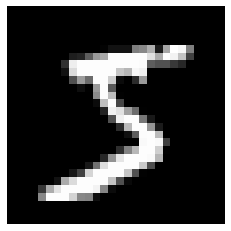

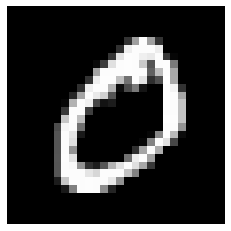

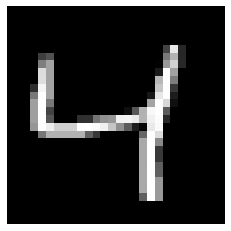

In [4]:
for i in range(3):
    plt.imshow(mnist_train.data[i], cmap="gray")
    plt.axis('off')
    plt.show()

In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [6]:
mnist_train.data[0].shape

torch.Size([28, 28])

# NF construction

Dimensionality of images:

In [71]:
d = 28
D = d ** 2

Latent distribution:

In [40]:
base_distribution = pyro.distributions.Normal(
    loc=torch.zeros((D,)),
    scale=torch.ones((D,))
)

We are going to stack a few coupling blocks:

In [61]:
n_blocks = 6
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_coupling(
            input_dim=D,
            hidden_dims=[32, 32, 32]
        )
    )
    blocks.append(
        pyro.distributions.transforms.permute(
            input_dim=D,
            permutation=torch.from_numpy(np.random.permutation(D))
        )
    )

In [62]:
transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=base_distribution,
    transforms=blocks
)

In [63]:
transformed_distribution.sample((2,)).shape

torch.Size([2, 784])

In [64]:
transformed_distribution.log_prob(torch.zeros((D,)))

tensor(-736.7251, grad_fn=<AddBackward0>)

# NF Training

In [72]:
modules = torch.nn.ModuleList([b for i, b in enumerate(blocks) if i%2 == 0])
optimizer = torch.optim.Adam(modules.parameters())
n_epochs = 100

In [68]:
pbar = trange(n_epochs)
for epoch in pbar:
    for x_batch, _ in trainloader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        loss = - transformed_distribution.log_prob(x_batch).mean()
        loss.backward()
        optimizer.step()

        transformed_distribution.clear_cache()
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|██████████| 5/5 [01:24<00:00, 16.93s/it, loss = -1264.504]


# Generated examples

In [69]:
n_examples = 3
generated_images = (
    transformed_distribution
    .sample((n_examples,))
    .detach()
    .view((n_examples, d, d))
    .numpy()
)

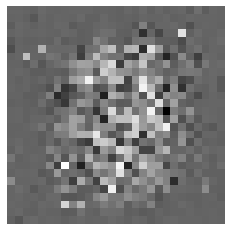

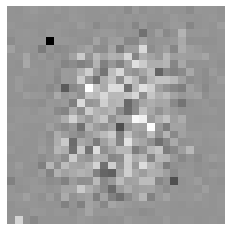

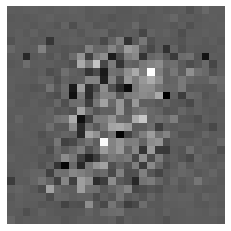

In [70]:
for i in range(n_examples):
    plt.imshow(generated_images[i], cmap="gray")
    plt.axis('off')
    plt.show()